# import

In [490]:
# !pip install opencv-python

In [449]:
# import scipy.io as sio
from skimage import io

import random
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

import torch, torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset # package x and y
import torch.optim as optim

from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import LabelEncoder as LE

import cv2 # image processing

In [1002]:
# check GPU
torch.cuda.is_available()

True

In [1210]:
print(torch.cuda.memory_allocated()) # tensor memory occupy (current)
print(torch.cuda.memory_reserved()) # all memory occupied by cache (current)
print(torch.cuda.max_memory_allocated()) # max memory occupied by tensor since run (max)

2177536
473956352
468624384


In [386]:
# example
example = np.random.randint(0,255,(10,1156))
example = example.reshape(10,1,34,34) # can use reshape directly to 4d
example.shape

(10, 1, 34, 34)

In [401]:
example[0]

array([[[165, 150, 173, ...,  13,  53, 151],
        [157, 132, 243, ...,  62, 217, 125],
        [ 79, 223, 180, ..., 220, 148, 235],
        ...,
        [ 26,  32, 191, ..., 104, 217, 213],
        [ 52,  86, 161, ..., 114, 118, 176],
        [ 13,  74, 240, ..., 132, 179,  45]]])

In [387]:
type(example)

numpy.ndarray

torch.Size([10, 1, 34, 34])


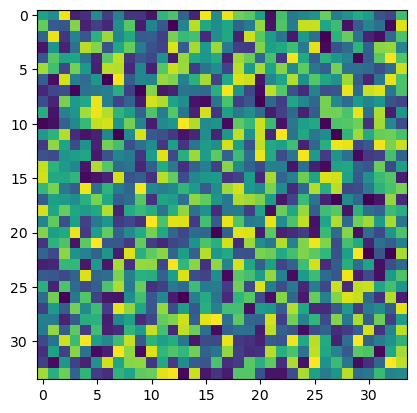

In [390]:
# example to tensor
example_tensor = torch.tensor(example)
print(example_tensor.shape)
plt.imshow(example_tensor.view(-1,34,34,1)[6]) # plt requires channel 1 to the last

# load datasets

## XY

In [8]:
# load X
data = pd.read_csv(r'dataset\participant_1152\XY1152.csv')
data = data.drop(data.columns[0], axis=1)

In [9]:
data.shape

(53444, 1153)

In [10]:
data.head()

,id,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,...,s6.X61_mv3,s6.X62_mv1,s6.X62_mv2,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3
0,amuse.p1.1,35.25,35.50,35.75,36.00,35.25,35.75,35.50,35.75,35.50,...,32.75,32.75,33.00,33.00,33.50,33.50,33.25,33.75,33.50,33.25
1,amuse.p1.1000,35.75,35.75,36.25,35.50,36.00,35.75,35.25,35.50,36.00,...,33.25,33.25,33.25,33.00,33.75,33.50,33.75,34.50,34.00,34.25
2,amuse.p1.1003,36.00,36.00,35.75,36.00,35.50,36.00,36.00,36.00,35.75,...,33.25,33.25,33.25,33.75,33.75,33.75,33.75,34.50,34.25,34.50
3,amuse.p1.1006,35.75,35.75,35.75,36.25,36.25,35.75,35.75,35.75,35.75,...,33.25,32.75,33.50,33.00,33.25,33.75,34.00,34.25,34.25,35.00
4,amuse.p1.1009,36.00,35.25,36.00,36.00,35.00,35.75,35.50,35.50,35.50,...,33.50,33.00,32.75,33.75,33.75,33.25,34.00,34.50,33.75,34.75


## handle na

In [12]:
# check nan
print(data.isnull().sum().sum()) 

122


Fill na with neighbour values

In [14]:
# fill na by forwarding neighbour values
data.fillna(method='ffill', inplace=True)
print(data.isnull().sum().sum()) 

0


## organise columns

In [ ]:
data['class'] = data['id']
data[['class','p','delete']] = data['id'].apply(lambda x: pd.Series(str(x).split('.')))
data.drop(columns='delete', inplace=True)

In [34]:
data.head()

,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X62_mv2,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3,class,p
0,35.25,35.50,35.75,36.00,35.25,35.75,35.50,35.75,35.50,35.75,...,33.00,33.00,33.50,33.50,33.25,33.75,33.50,33.25,amuse,p1
1,35.75,35.75,36.25,35.50,36.00,35.75,35.25,35.50,36.00,36.25,...,33.25,33.00,33.75,33.50,33.75,34.50,34.00,34.25,amuse,p1
2,36.00,36.00,35.75,36.00,35.50,36.00,36.00,36.00,35.75,36.00,...,33.25,33.75,33.75,33.75,33.75,34.50,34.25,34.50,amuse,p1
3,35.75,35.75,35.75,36.25,36.25,35.75,35.75,35.75,35.75,36.25,...,33.50,33.00,33.25,33.75,34.00,34.25,34.25,35.00,amuse,p1
4,36.00,35.25,36.00,36.00,35.00,35.75,35.50,35.50,35.50,35.75,...,32.75,33.75,33.75,33.25,34.00,34.50,33.75,34.75,amuse,p1


In [38]:
first_col = data.pop('id')
data.insert(1154, 'id', first_col)
data.shape

(53444, 1155)

In [39]:
data.head()

,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3,class,p,id
0,35.25,35.50,35.75,36.00,35.25,35.75,35.50,35.75,35.50,35.75,...,33.00,33.50,33.50,33.25,33.75,33.50,33.25,amuse,p1,amuse.p1.1
1,35.75,35.75,36.25,35.50,36.00,35.75,35.25,35.50,36.00,36.25,...,33.00,33.75,33.50,33.75,34.50,34.00,34.25,amuse,p1,amuse.p1.1000
2,36.00,36.00,35.75,36.00,35.50,36.00,36.00,36.00,35.75,36.00,...,33.75,33.75,33.75,33.75,34.50,34.25,34.50,amuse,p1,amuse.p1.1003
3,35.75,35.75,35.75,36.25,36.25,35.75,35.75,35.75,35.75,36.25,...,33.00,33.25,33.75,34.00,34.25,34.25,35.00,amuse,p1,amuse.p1.1006
4,36.00,35.25,36.00,36.00,35.00,35.75,35.50,35.50,35.50,35.75,...,33.75,33.75,33.25,34.00,34.50,33.75,34.75,amuse,p1,amuse.p1.1009


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53444 entries, 0 to 53443
Columns: 1153 entries, id to s6.X64_mv3
dtypes: float64(1152), object(1)
memory usage: 470.1+ MB


In [40]:
# save full dataset to file
data.to_csv('dataset\participant_1152\py_XY1152.csv', index=False)

# Reload full dataset `XY1152.csv`

In [477]:
# !pip3 install --upgrade pandas  --user

In [478]:
data = pd.read_csv('dataset\participant_1152\py_XY1152.csv')
# data = data.drop(data.columns[0], axis=1)
print(data.shape)

OSError: [Errno 22] Invalid argument: 'dataset\\participant_1152\\py_XY1152.csv'

In [479]:
data.head()

,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3,class,p,id
0,35.25,35.50,35.75,36.00,35.25,35.75,35.50,35.75,35.50,35.75,...,33.00,33.50,33.50,33.25,33.75,33.50,33.25,amuse,p1,amuse.p1.1
1,35.75,35.75,36.25,35.50,36.00,35.75,35.25,35.50,36.00,36.25,...,33.00,33.75,33.50,33.75,34.50,34.00,34.25,amuse,p1,amuse.p1.1000
2,36.00,36.00,35.75,36.00,35.50,36.00,36.00,36.00,35.75,36.00,...,33.75,33.75,33.75,33.75,34.50,34.25,34.50,amuse,p1,amuse.p1.1003
3,35.75,35.75,35.75,36.25,36.25,35.75,35.75,35.75,35.75,36.25,...,33.00,33.25,33.75,34.00,34.25,34.25,35.00,amuse,p1,amuse.p1.1006
4,36.00,35.25,36.00,36.00,35.00,35.75,35.50,35.50,35.50,35.75,...,33.75,33.75,33.25,34.00,34.50,33.75,34.75,amuse,p1,amuse.p1.1009


## split to 17/1

In [ ]:
# overall split by 17 / 1
train = data.loc[data['p'] != 'p18', :] 
test = data.loc[data['p'] == 'p18', :]

In [480]:
train.shape

(50473, 1155)

## Shuffle 17 (train)

Shuffle and reset index

In [70]:
# shuffle all rows using sample() with frac=1, then reset index
train = train.sample(frac=1).reset_index(drop=True)

In [71]:
train.head()

,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3,class,p,id
0,38.25,38.25,38.50,38.00,38.25,38.75,38.50,38.25,38.50,38.00,...,35.5,35.50,35.75,36.25,36.50,36.50,36.50,count,p2,count.p2.389
1,38.00,38.00,38.25,38.00,38.00,38.25,38.00,37.50,37.75,37.75,...,33.0,33.25,33.00,33.75,34.00,34.00,34.00,focus,p15,focus.p15.340
2,37.00,37.25,37.25,37.00,37.25,37.25,37.00,37.00,37.25,37.25,...,35.0,36.00,35.25,35.25,36.00,36.00,36.25,sadness,p8,sadness.p8.267
3,37.50,37.00,38.00,37.25,37.25,37.25,37.50,37.50,37.00,37.25,...,34.5,34.25,34.00,34.25,35.00,34.75,34.50,disgust,p16,disgust.p16.312
4,37.00,37.25,37.25,37.75,37.50,36.75,37.25,37.50,37.00,37.25,...,31.0,31.50,31.25,31.75,32.25,32.50,32.00,amuse,p15,amuse.p15.877


## check outliers and drop rows

In [572]:
min_list = train.describe().T.loc[:, 'min']
min_list.value_counts()

31.25    211
31.50    150
32.00    141
31.75    116
31.00    112
32.25    105
32.50     71
29.75     57
30.00     49
30.75     36
30.25     31
29.50     29
30.50     22
32.75      8
29.25      7
29.00      4
0.75       1
28.75      1
1.30       1
Name: min, dtype: int64

In [573]:
print(train.shape)
print(train[~(train.iloc[:,0:1152] <= 5).any(axis=1)].shape)

(50473, 1155)
(50471, 1155)


In [575]:
# drop rows with extreme low channel values: <=5 (0.75, 1.3, etc..)
train = train[~(train.iloc[:, 0:1152] <= 5).any(axis=1)]
test = test[~(test.iloc[:, 0:1152] <= 5).any(axis=1)]

In [576]:
train.describe().T.loc[:,'min'].value_counts()

31.25    211
31.50    150
32.00    141
31.75    117
31.00    112
32.25    105
32.50     71
29.75     58
30.00     49
30.75     36
30.25     31
29.50     29
30.50     22
32.75      8
29.25      7
29.00      4
28.75      1
Name: min, dtype: int64

## reset index

In [584]:
# reset index
train.index = range(train.shape[0])
test.index = range(test.shape[0])

## split to Xtrain Xtest Ytrain Ytest

In [618]:
# train/test split 
Xtrain = train.iloc[:, 0:1152]
Xtest = test.iloc[:, 0:1152]
Ytrain = train.loc[:, 'class']
Ytest = test.loc[:, 'class']
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(50471, 1152) (2971, 1152) (50471,) (2971,)


## Normalize

Normalize to image-like 0~255, and try as 'uint8'

In [619]:
Xtrain.min().min(), Xtrain.max().max()

(28.75, 40.75)

In [620]:
Xtrain.columns

Index(['s1.X1_mv1', 's1.X1_mv2', 's1.X1_mv3', 's1.X2_mv1', 's1.X2_mv2',
       's1.X2_mv3', 's1.X3_mv1', 's1.X3_mv2', 's1.X3_mv3', 's1.X4_mv1',
       ...
       's6.X61_mv3', 's6.X62_mv1', 's6.X62_mv2', 's6.X62_mv3', 's6.X63_mv1',
       's6.X63_mv2', 's6.X63_mv3', 's6.X64_mv1', 's6.X64_mv2', 's6.X64_mv3'],
      dtype='object', length=1152)

In [621]:
# normalize to 0~255
Xtrain_scale = np.array(Xtrain.copy())
Xtrain_scale = cv2.normalize(Xtrain_scale, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
Xtrain_scale = pd.DataFrame(Xtrain_scale, columns=Xtrain.columns)
Xtrain_scale.shape

(50471, 1152)

In [625]:
Xtrain_scale.min().min(), Xtrain_scale.max().max()

(0.0, 255.0)

In [623]:
Xtrain_scale.head()

,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X61_mv3,s6.X62_mv1,s6.X62_mv2,s6.X62_mv3,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3
0,201.8750,201.8750,207.1875,196.5625,201.8750,212.500,207.1875,201.8750,207.1875,196.5625,...,148.7500,148.7500,154.0625,143.4375,143.4375,148.7500,159.375,164.6875,164.6875,164.6875
1,196.5625,196.5625,201.8750,196.5625,196.5625,201.875,196.5625,185.9375,191.2500,191.2500,...,95.6250,100.9375,100.9375,90.3125,95.6250,90.3125,106.250,111.5625,111.5625,111.5625
2,175.3125,180.6250,180.6250,175.3125,180.6250,180.625,175.3125,175.3125,180.6250,180.6250,...,138.1250,132.8125,138.1250,132.8125,154.0625,138.1250,138.125,154.0625,154.0625,159.3750
3,185.9375,175.3125,196.5625,180.6250,180.6250,180.625,185.9375,185.9375,175.3125,180.6250,...,122.1875,111.5625,116.8750,122.1875,116.8750,111.5625,116.875,132.8125,127.5000,122.1875
4,175.3125,180.6250,180.6250,191.2500,185.9375,170.000,180.6250,185.9375,175.3125,180.6250,...,53.1250,58.4375,53.1250,47.8125,58.4375,53.1250,63.750,74.3750,79.6875,69.0625


In [624]:
# apply the same to Xtest
Xtest_scale = np.array(Xtest.copy())
Xtest_scale = cv2.normalize(Xtest_scale, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
Xtest_scale = pd.DataFrame(Xtest_scale, columns=Xtest.columns)
Xtest_scale.shape

(2971, 1152)

## Add 4 features
- mean
- median
- range
- std

In [626]:
Xtrain_scale['mean'] = Xtrain_scale.iloc[:, 0:1152].mean(axis=1)
Xtrain_scale['median'] = Xtrain_scale.iloc[:, 0:1152].median(axis=1)
Xtrain_scale['range'] = Xtrain_scale.iloc[:, 0:1152].max(axis=1) - Xtrain_scale.iloc[:, 0:1152].min(axis=1)
Xtrain_scale['std'] = Xtrain_scale.iloc[:, 0:1152].std(axis=1)
Xtest_scale['mean'] = Xtest_scale.iloc[:, 0:1152].mean(axis=1)
Xtest_scale['median'] = Xtest_scale.iloc[:, 0:1152].median(axis=1)
Xtest_scale['range'] = Xtest_scale.iloc[:, 0:1152].max(axis=1) - Xtest_scale.iloc[:, 0:1152].min(axis=1)
Xtest_scale['std'] = Xtest_scale.iloc[:, 0:1152].std(axis=1)
print(Xtrain_scale.shape, Xtest_scale.shape, Ytrain.shape, Ytest.shape)

(50471, 1156) (2971, 1156) (50471,) (2971,)


In [627]:
print(Xtrain_scale.shape)
Xtrain_scale.head()

(50471, 1156)


,s1.X1_mv1,s1.X1_mv2,s1.X1_mv3,s1.X2_mv1,s1.X2_mv2,s1.X2_mv3,s1.X3_mv1,s1.X3_mv2,s1.X3_mv3,s1.X4_mv1,...,s6.X63_mv1,s6.X63_mv2,s6.X63_mv3,s6.X64_mv1,s6.X64_mv2,s6.X64_mv3,mean,median,range,std
0,201.8750,201.8750,207.1875,196.5625,201.8750,212.500,207.1875,201.8750,207.1875,196.5625,...,143.4375,148.7500,159.375,164.6875,164.6875,164.6875,178.139374,185.9375,106.250,24.760309
1,196.5625,196.5625,201.8750,196.5625,196.5625,201.875,196.5625,185.9375,191.2500,191.2500,...,95.6250,90.3125,106.250,111.5625,111.5625,111.5625,165.374619,175.3125,138.125,31.233812
2,175.3125,180.6250,180.6250,175.3125,180.6250,180.625,175.3125,175.3125,180.6250,180.6250,...,154.0625,138.1250,138.125,154.0625,154.0625,159.3750,163.580734,164.6875,85.000,15.363285
3,185.9375,175.3125,196.5625,180.6250,180.6250,180.625,185.9375,185.9375,175.3125,180.6250,...,116.8750,111.5625,116.875,132.8125,127.5000,122.1875,158.821609,164.6875,116.875,23.197155
4,175.3125,180.6250,180.6250,191.2500,185.9375,170.000,180.6250,185.9375,175.3125,180.6250,...,58.4375,53.1250,63.750,74.3750,79.6875,69.0625,149.520126,159.3750,159.375,38.468922


In [73]:
# # load Y
# train_Y = pd.read_csv(r'dataset\train\train_Y.csv')
# train_Y = train_Y.drop(train_Y.columns[0], axis=1)
# test_Y = pd.read_csv(r'dataset\test\test_Y.csv')
# test_Y = test_Y.drop(test_Y.columns[0], axis=1)
# print(train_Y.shape, test_Y.shape)

# train_Y.rename(columns={'x':'label'}, inplace=True)
# train_Y[['label', 'p','source']] = train_Y.label.str.split('.', expand=True)
# test_Y.rename(columns={'x':'label'}, inplace=True)
# test_Y[['label', 'p','source']] = test_Y.label.str.split('.', expand=True)
# train_Y.head()

In [628]:
Ytrain

0            count
1            focus
2          sadness
3          disgust
4            amuse
           ...    
50466        focus
50467        relax
50468        count
50469    surprise1
50470         fear
Name: class, Length: 50471, dtype: object

In [1004]:
data['class'].value_counts()

fear         11009
surprise2     9862
amuse         8047
anger         4831
focus         4234
disgust       3861
count         3259
relax         2841
relax2        2248
surprise1     1629
sadness       1623
Name: class, dtype: int64

In [ ]:
positive = ['amuse','relax','relax2','','','']
negative = ['fear','','','','','']

Number of class in Ytrain

In [630]:
np.unique(Ytrain)

array(['amuse', 'anger', 'count', 'disgust', 'fear', 'focus', 'relax',
       'relax2', 'sadness', 'surprise1', 'surprise2'], dtype=object)

## Write normalized data to files

In [634]:
# save to files
Xtrain_scale.to_csv(r'G:\My Drive\U\2022_WORK_UNISA\WORK_UNISA\Digital Capabilities Program\project_rehabSwift\stroke-sensors\dataset\train\Xtrain_scale.csv', index=False)
Xtest_scale.to_csv(r'G:\My Drive\U\2022_WORK_UNISA\WORK_UNISA\Digital Capabilities Program\project_rehabSwift\stroke-sensors\dataset\test\Xtest_scale.csv',index=False)
Ytrain.to_csv(r'G:\My Drive\U\2022_WORK_UNISA\WORK_UNISA\Digital Capabilities Program\project_rehabSwift\stroke-sensors\dataset\train\Ytrain.csv', index=False)
Ytest.to_csv(r'G:\My Drive\U\2022_WORK_UNISA\WORK_UNISA\Digital Capabilities Program\project_rehabSwift\stroke-sensors\dataset\test\Ytest.csv', index=False)

# [Optional] Reload Xtrain Xtest Ytrain Ytest

In [206]:
# # reload
# Xtrain_scale = pd.read_csv('dataset/train/Xtrain_scale.csv')
# Xtest_scale = pd.read_csv('dataset/test/Xtest_scale.csv')
# Ytrain = pd.read_csv('dataset/train/Ytrain.csv')
# Ytest = pd.read_csv('dataset/test/Ytest.csv')
# print(Xtrain_scale.shape, Xtest_scale.shape, Ytrain.shape, Ytest.shape)

# Reference model

In [676]:
Ytrain[:2000]

0           count
1           focus
2         sadness
3         disgust
4           amuse
          ...    
1995    surprise2
1996      disgust
1997        anger
1998        focus
1999        count
Name: class, Length: 2000, dtype: object

In [677]:
# train a LR with 5000 samples
Xtrain_sample, Xtest_sample,Ytrain_sample,Ytest_sample = TTS(Xtrain[:2000],Ytrain[:2000],test_size=0.4, random_state=420)

In [678]:
# np.unique(Ytrain_sample)

In [679]:
# TIME WARNING: 10 mins
clf = LR(random_state=420, solver='newton-cg').fit(Xtrain_sample, Ytrain_sample)

C:\Users\EricWang\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [680]:
clf.score(Xtrain_sample, Ytrain_sample)

1.0

In [681]:
clf.score(Xtest_sample, Ytest_sample)

0.39125

In [208]:
# Xtest_sample.head()

In [132]:
# select top n important features
# weights = pd.DataFrame(abs(clf.coef_).mean(axis=0))
# weights.sort_values(by=0, ascending=False).iloc[:1089, 0].index
# idx = weights.sort_values(by=0, ascending=False).iloc[:1089,0].index # desc sort feature weights，then get first 1089 index

In [ ]:
# polynomial dimensionality increase
# poly = PF(degree=2, interaction_only=True).fit(Xtrain_arr) 
# Xtrain_arr_ = poly.transform(Xtrain_arr)
# Xtest_arr_ = poly.transform(Xtest_arr)
# TIME WARNING: 40 mins
# clf_ = LR(random_state=420, max_iter=100, solver='newton-cg').fit(Xtrain_arr_, Ytrain_arr)
# clf_.score(Xtrain_arr_, Ytrain_arr)
# clf_.score(Xtest_arr_, Ytest_arr)

# to array, reshape & to tensor

using **scaled data**

In [657]:
# to array
Xtrain_arr = Xtrain_scale.to_numpy()
Xtest_arr = Xtest_scale.to_numpy()
Ytrain_arr = Ytrain.values
Ytest_arr = Ytest.values

In [659]:
# reshape
Xtrain_arr = Xtrain_arr.reshape(Xtrain_arr.shape[0], 1, 34,34)
Xtest_arr = Xtest_arr.reshape(Xtest_arr.shape[0], 1, 34,34)
print(Xtrain_arr.shape, Xtest_arr.shape)

(50471, 1, 34, 34) (2971, 1, 34, 34)


In [660]:
# to tensor
Xtrain_ts = torch.tensor(Xtrain_arr)
Xtest_ts = torch.tensor(Xtest_arr)
print(Xtrain_ts.shape, Xtest_ts.shape)

torch.Size([50471, 1, 34, 34]) torch.Size([2971, 1, 34, 34])


In [675]:
Xtrain_ts[-1]

tensor([[[196.5625, 196.5625, 191.2500,  ..., 191.2500, 191.2500, 196.5625],
         [196.5625, 185.9375, 185.9375,  ..., 191.2500, 196.5625, 201.8750],
         [185.9375, 201.8750, 201.8750,  ..., 180.6250, 180.6250, 191.2500],
         ...,
         [170.0000, 164.6875, 159.3750,  ..., 164.6875, 164.6875, 159.3750],
         [154.0625, 154.0625, 154.0625,  ..., 154.0625, 164.6875, 154.0625],
         [159.3750, 143.4375, 154.0625,  ..., 180.6250,  95.6250,  16.2963]]])

# Assemble complete dataset (X + Y)

## encode label

In [662]:
print(np.unique(Ytrain_arr))
Ytrain_arr[0]

['amuse' 'anger' 'count' 'disgust' 'fear' 'focus' 'relax' 'relax2'
 'sadness' 'surprise1' 'surprise2']


'count'

In [663]:
le = LE()
le.fit(Ytrain_arr)

LabelEncoder()

In [664]:
list(le.classes_)

['amuse',
 'anger',
 'count',
 'disgust',
 'fear',
 'focus',
 'relax',
 'relax2',
 'sadness',
 'surprise1',
 'surprise2']

In [670]:
Ytrain_enc = le.transform(Ytrain_arr)
Ytest_enc = le.transform(Ytest_arr)
Ytrain_enc

array([2, 5, 8, ..., 2, 9, 4])

In [666]:
# Ytrain_enc = np.array(Ytrain_enc)
# Ytest_enc = np.array(Ytest_enc)

In [671]:
np.unique(Ytrain_enc)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## dataset package using scaled data

using **scaled data**

In [672]:
# package up
dataset_train = TensorDataset(Xtrain_ts, torch.tensor(Ytrain_enc))
dataset_test = TensorDataset(Xtest_ts, torch.tensor(Ytest_enc))

In [1068]:
dataset_train[0][1]

tensor(2, dtype=torch.int32)

In [1130]:
# print(Xtrain_ts.max().item(), Xtrain_ts.min().item())

In [1098]:
class CustomDataset(Dataset):
    
    def __init__(self, Xtrain, Ytrain, transform=None):
        '''
        Xtrain: dataframe
        Ytrain: dataframe
        transform: 
        '''
        super().__init__()
        self.x = Xtrain.values
        self.x = self.x.reshape(-1,1,34,34)
        
        self.y = Ytrain.values # categories
        self.transform = transform
        
        le = LE() # label encoder
        self.y = le.fit_transform(self.y) # encoded categories
        
        self.xtrain = torch.tensor(self.x, dtype=torch.float32)
        self.ytrain = torch.tensor(self.y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.ytrain)
    
    def __info__(self):
        print('CustomData')
    
    def __getitem__(self, idx):
        if self.transform != None:
            self.xtrain = self.transform(self.xtrain)
            
        return self.xtrain[idx], self.ytrain[idx]

In [1123]:
transform = transforms.Compose([transforms.CenterCrop(32) # crop to size: 32x32
#                                , transforms.Normalize(0.5,0.5)
                               ])

In [1127]:
dataset_train = CustomDataset(Xtrain_scale, Ytrain, transform)

In [1142]:
for i, (inputs, labels) in enumerate(dataset_train):
    print(i, inputs.shape, labels)
    break

0 torch.Size([1, 32, 32]) tensor(2.)


In [1145]:
dataset_train.__len__()

50471

In [1139]:
# Same to generate test dataset
dataset_test = CustomDataset(Xtest_scale, Ytest, transform)

In [1141]:
for i, (inputs, labels) in enumerate(dataset_test):
    print(i, inputs.shape, labels)
    break

0 torch.Size([1, 32, 32]) tensor(0.)


## Resize & Crop [Optional]

CenterCrop to 32*32

In [ ]:
# use transforms.Compose() to pack some steps together
transform = transforms.Compose([transforms.CenterCrop(32)]) # crop to size: 32x32

In [793]:
dataset_train[0][1]

tensor(2, dtype=torch.int32)

In [800]:
type(dataset_train)

torch.utils.data.dataset.TensorDataset

In [811]:
dataset_train[0]

(tensor([[[201.8750, 201.8750, 207.1875,  ..., 196.5625, 196.5625, 196.5625],
          [196.5625, 201.8750, 196.5625,  ..., 207.1875, 207.1875, 201.8750],
          [212.5000, 207.1875, 217.8125,  ..., 196.5625, 196.5625, 201.8750],
          ...,
          [154.0625, 154.0625, 143.4375,  ..., 138.1250, 132.8125, 143.4375],
          [132.8125, 138.1250, 148.7500,  ..., 143.4375, 132.8125, 143.4375],
          [154.0625, 148.7500, 148.7500,  ..., 185.9375, 106.2500,  24.7603]]]),
 tensor(2, dtype=torch.int32))

In [929]:
torch.tensor(dataset_train[0][0].numpy().astype('uint8'))

tensor([[[201, 201, 207,  ..., 196, 196, 196],
         [196, 201, 196,  ..., 207, 207, 201],
         [212, 207, 217,  ..., 196, 196, 201],
         ...,
         [154, 154, 143,  ..., 138, 132, 143],
         [132, 138, 148,  ..., 143, 132, 143],
         [154, 148, 148,  ..., 185, 106,  24]]], dtype=torch.uint8)

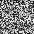

In [934]:
transforms.functional.to_pil_image(dataset_train[0][0])

In [935]:
transforms.functional.to_tensor(transforms.functional.to_pil_image(dataset_train[0][0]))

tensor([[[0.0863, 0.0863, 0.3765,  ..., 0.7961, 0.7961, 0.7961],
         [0.7961, 0.0863, 0.7961,  ..., 0.3765, 0.3765, 0.0863],
         [0.6706, 0.3765, 0.9647,  ..., 0.7961, 0.7961, 0.0863],
         ...,
         [0.4588, 0.4588, 0.8784,  ..., 0.5843, 0.2941, 0.8784],
         [0.2941, 0.5843, 0.1686,  ..., 0.8784, 0.2941, 0.8784],
         [0.4588, 0.1686, 0.1686,  ..., 0.2118, 0.8353, 0.6627]]])

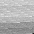

In [931]:
transforms.functional.to_pil_image(torch.tensor(dataset_train[0][0].numpy().astype('uint8')))

In [932]:
transforms.functional.to_tensor(transforms.functional.to_pil_image(torch.tensor(dataset_train[0][0].numpy().astype('uint8'))))

tensor([[[0.7882, 0.7882, 0.8118,  ..., 0.7686, 0.7686, 0.7686],
         [0.7686, 0.7882, 0.7686,  ..., 0.8118, 0.8118, 0.7882],
         [0.8314, 0.8118, 0.8510,  ..., 0.7686, 0.7686, 0.7882],
         ...,
         [0.6039, 0.6039, 0.5608,  ..., 0.5412, 0.5176, 0.5608],
         [0.5176, 0.5412, 0.5804,  ..., 0.5608, 0.5176, 0.5608],
         [0.6039, 0.5804, 0.5804,  ..., 0.7255, 0.4157, 0.0941]]])

Define a function to transform image
- Center crop to size 32x32

In [1009]:
class TensorDatasetTransform_32(TensorDataset):
    r"""Dataset wrapping tensors.
    Each sample will be retrieved by indexing tensors along the first dimension.
    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """
#     tensors: Tuple[Tensor, ...]

    def __init__(self, tensor):
        self.tensor = tensor
        self.center_crop = transforms.CenterCrop(32)

    def __info__(self):
        print('Transform TensorDataset')
        print('\t Number of samples: {}'.format(len(self.tensor)))
#         print('\t Number of classes: {}'.format(len(np.unique(self.tensor)))
        print('\t root_dir: {}'.format(self.root_dir))
    
    def __getitem__(self, index):
#         print('index:', index)
        out = self.tensor[index] # get the tuple containing tensor and label
        out = transforms.functional.to_pil_image(torch.tensor(out[0].numpy().astype('uint8'))) # out[0] is the tensor part of the tuple
        out = self.center_crop(out)
        out = transforms.functional.to_tensor(out)
        return out, self.tensor[index][1].item() # re-assemble dataset, and using label value instead of label tensor
#         return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return len(self.tensor) # .size(0)

In [1010]:
dataset_train_ = TensorDatasetTransform_32(dataset_train)
dataset_train_

In [1011]:
dataset_train_.__len__()

50471

In [1012]:
dataset_train_[0]

(tensor([[[0.7882, 0.7686, 0.7686,  ..., 0.7882, 0.8118, 0.8118],
          [0.8118, 0.8510, 0.8745,  ..., 0.8118, 0.7686, 0.7686],
          [0.7490, 0.7686, 0.7686,  ..., 0.8118, 0.7882, 0.7882],
          ...,
          [0.5608, 0.5176, 0.5176,  ..., 0.5176, 0.5608, 0.5412],
          [0.6039, 0.5608, 0.5608,  ..., 0.5608, 0.5412, 0.5176],
          [0.5412, 0.5804, 0.5608,  ..., 0.5412, 0.5608, 0.5176]]]),
 2)

In [1013]:
# random images
def plotsample_(data):
    fig, axs = plt.subplots(1,5,figsize=(10,10))
    for i in range(5):
        num = random.randint(0,len(data)-1)
        tupl = data[num]
        npimg = torchvision.utils.make_grid(tupl[0])
        nplabel = tupl[1]
        
        axs[i].imshow(np.transpose(npimg, (1,2,0)))
        axs[i].set_title(nplabel)
#         axs[i].axis('off')

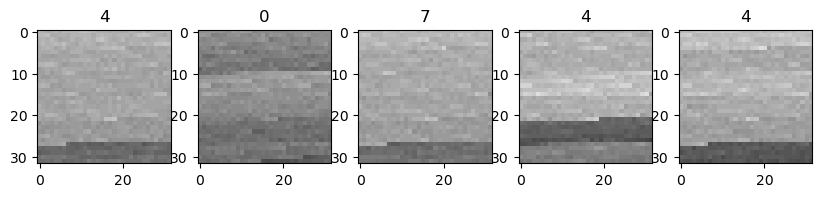

In [1014]:
plotsample_(dataset_train_)

In [981]:
# img_list = []
# for i in range(5):
#     img_list.append(random.randint(0, len(dataset_train_)-1))
# print(img_list)

# fig, axs = plt.subplots(1,5,figsize=(10,10))
# for i in range(5):
#     tupl = dataset_train_[img_list[i]]
#     img = tupl[0]
#     lbl = tupl[1]
#     axs[i].imshow(np.transpose(img.numpy(), (1,2,0)))
#     axs[i].set_title(lbl)

In [894]:
# img_list = []
# for i in range(5):
#     img_list.append(random.randint(0, len(dataset_train_)-1))
# print(img_list)
    
# fig, axs = plt.subplots(1,5,figsize=(10,10))
# axs[0].imshow(np.transpose(dataset_train_[img_list[0]][0].numpy(), (1,2,0)))
# axs[1].imshow(np.transpose(dataset_train_[img_list[1]][0].numpy(), (1,2,0)))
# axs[2].imshow(np.transpose(dataset_train_[img_list[2]][0].numpy(), (1,2,0)))
# axs[3].imshow(np.transpose(dataset_train_[img_list[3]][0].numpy(), (1,2,0)))
# axs[4].imshow(np.transpose(dataset_train_[img_list[4]][0].numpy(), (1,2,0)))
# axs[0].set_title(dataset_train_[img_list[0]][1])
# axs[1].set_title(dataset_train_[img_list[1]][1])
# axs[2].set_title(dataset_train_[img_list[2]][1])
# axs[3].set_title(dataset_train_[img_list[3]][1])
# axs[4].set_title(dataset_train_[img_list[4]][1])

## dataset package using original data [Optinal] 

using non-normalized data, in case want to compare

In [707]:
# [Optional] package up using original values (non-normalized data) by repeating the same steps
# add same features
Xtrain['mean'] = Xtrain.iloc[:, 0:1152].mean(axis=1)
Xtrain['median'] = Xtrain.iloc[:, 0:1152].median(axis=1)
Xtrain['range'] = Xtrain.iloc[:, 0:1152].max(axis=1) - Xtrain.iloc[:, 0:1152].min(axis=1)
Xtrain['std'] = Xtrain.iloc[:, 0:1152].std(axis=1)
Xtest['mean'] = Xtest.iloc[:, 0:1152].mean(axis=1)
Xtest['median'] = Xtest.iloc[:, 0:1152].median(axis=1)
Xtest['range'] = Xtest.iloc[:, 0:1152].max(axis=1) - Xtest.iloc[:, 0:1152].min(axis=1)
Xtest['std'] = Xtest.iloc[:, 0:1152].std(axis=1)
# to array
Xtrain_arr_non_norm = Xtrain.to_numpy()
Xtest_arr_non_norm = Xtest.to_numpy()
# reshape
Xtrain_arr_non_norm = Xtrain_arr_non_norm.reshape(Xtrain_arr_non_norm.shape[0], 1, 34,34)
Xtest_arr_non_norm = Xtest_arr_non_norm.reshape(Xtest_arr_non_norm.shape[0], 1, 34,34)
# to tensor and package
dataset_train_non_norm = TensorDataset(torch.tensor(Xtrain_arr_non_norm), torch.tensor(Ytrain_enc))
dataset_test_non_norm = TensorDataset(torch.tensor(Xtest_arr_non_norm), torch.tensor(Ytest_enc))

# Visualise 

## Visualise 1 image

In [708]:
# now dataset looks like:
for x,y in dataset_xtrain:
    print(x.shape, y.item())
    break

torch.Size([1, 34, 34]) 2


In [685]:
print(Ytrain_arr[0], Ytrain_enc[0])
print(Ytrain_arr[4], Ytrain_enc[4])
print(Ytrain_arr[100], Ytrain_enc[100])

count 2
amuse 0
surprise2 10


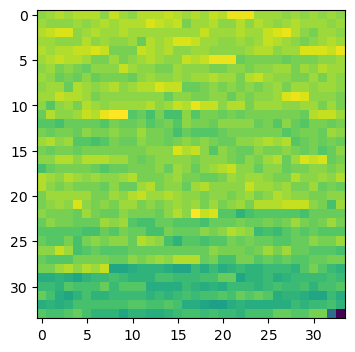

In [755]:
# visualise one sample image
plt.figure(figsize=(4,4))
plt.imshow(Xtrain_ts.view(-1,34,34,1)[5])
plt.show()

In [709]:
# Xtrain_ts.view(-1,34,34,1)[5].numpy().astype('uint8')

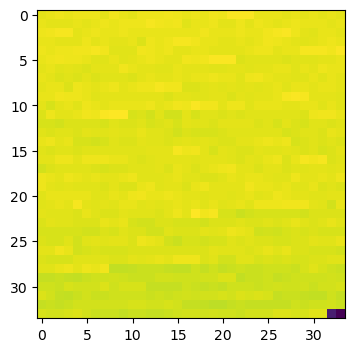

In [710]:
# visualise original values
plt.figure(figsize=(4,4))
plt.imshow(torch.tensor(Xtrain_arr_non_norm).view(-1,34,34,1)[5])
plt.show()

## Visualise random images

In [694]:
dataset_train[224][0]

tensor([[[185.9375, 185.9375, 196.5625,  ..., 180.6250, 185.9375, 175.3125],
         [175.3125, 185.9375, 180.6250,  ..., 185.9375, 180.6250, 185.9375],
         [185.9375, 196.5625, 191.2500,  ..., 175.3125, 170.0000, 170.0000],
         ...,
         [170.0000, 170.0000, 148.7500,  ..., 143.4375, 148.7500, 148.7500],
         [143.4375, 143.4375, 143.4375,  ..., 154.0625, 148.7500, 154.0625],
         [159.3750, 154.0625, 143.4375,  ..., 164.6875, 100.9375,  18.0217]]])

[35236, 7092, 17836, 19395, 11086]


Text(0.5, 1.0, '0')

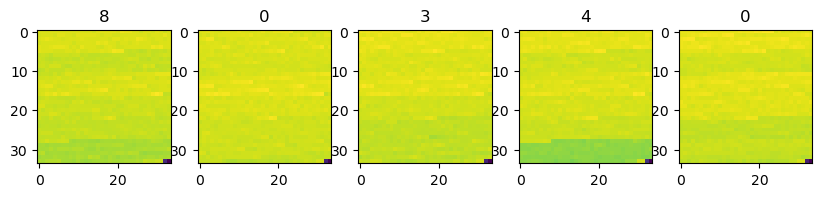

In [1133]:
img = []
for i in range(5):
    img.append(random.randint(0, len(dataset_train)-1))
print(img)
    
fig, axs = plt.subplots(1,5,figsize=(10,10))
axs[0].imshow(np.transpose(dataset_train_non_norm[img[0]][0].numpy(), (1,2,0)))
axs[1].imshow(np.transpose(dataset_train_non_norm[img[1]][0].numpy(), (1,2,0)))
axs[2].imshow(np.transpose(dataset_train_non_norm[img[2]][0].numpy(), (1,2,0)))
axs[3].imshow(np.transpose(dataset_train_non_norm[img[3]][0].numpy(), (1,2,0)))
axs[4].imshow(np.transpose(dataset_train_non_norm[img[4]][0].numpy(), (1,2,0)))
axs[0].set_title(dataset_train_non_norm[img[0]][1].item())
axs[1].set_title(dataset_train_non_norm[img[1]][1].item())
axs[2].set_title(dataset_train_non_norm[img[2]][1].item())
axs[3].set_title(dataset_train_non_norm[img[3]][1].item())
axs[4].set_title(dataset_train_non_norm[img[4]][1].item())

[32888, 45024, 41708, 12751, 23301]


Text(0.5, 1.0, '7.0')

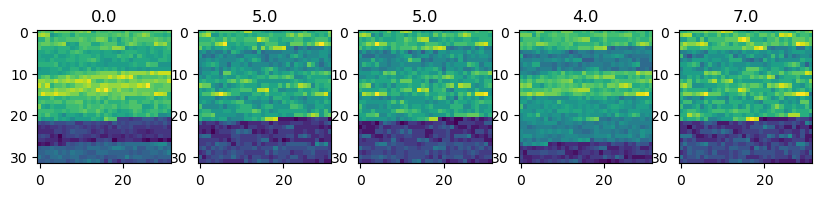

In [1134]:
img = []
for i in range(5):
    img.append(random.randint(0, len(dataset_train)-1))
print(img)
    
fig, axs = plt.subplots(1,5,figsize=(10,10))
axs[0].imshow(np.transpose(dataset_train[img[0]][0].numpy(), (1,2,0)))
axs[1].imshow(np.transpose(dataset_train[img[1]][0].numpy(), (1,2,0)))
axs[2].imshow(np.transpose(dataset_train[img[2]][0].numpy(), (1,2,0)))
axs[3].imshow(np.transpose(dataset_train[img[3]][0].numpy(), (1,2,0)))
axs[4].imshow(np.transpose(dataset_train[img[4]][0].numpy(), (1,2,0)))
axs[0].set_title(dataset_train[img[0]][1].item())
axs[1].set_title(dataset_train[img[1]][1].item())
axs[2].set_title(dataset_train[img[2]][1].item())
axs[3].set_title(dataset_train[img[3]][1].item())
axs[4].set_title(dataset_train[img[4]][1].item())

In [945]:
# random images
def plotsample(data):
    fig, axs = plt.subplots(1,5,figsize=(10,10))
    for i in range(5):
        num = random.randint(0,len(data)-1)
        print('num:', num)
        
        npimg = torchvision.utils.make_grid(data[num][0]).numpy().astype('int')
        nplabel = data[num][1].item()
        
        axs[i].imshow(np.transpose(npimg, (1,2,0)))
        axs[i].set_title(nplabel)
#         axs[i].axis('off')

num: 1076
num: 46333
num: 9657
num: 5660
num: 39511


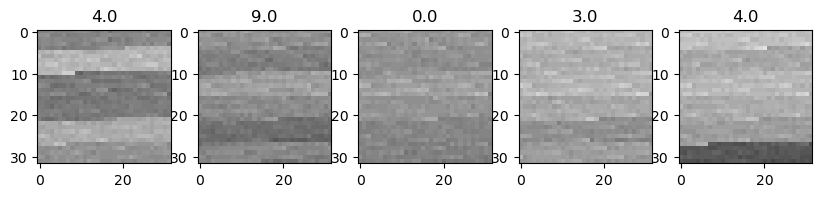

In [1135]:
plotsample(dataset_train)

In [785]:
# torchvision.utils.make_grid(dataset_train[174][0]).numpy().round(0)

In [786]:
# plt.imshow(torchvision.utils.make_grid(dataset_train[174][0]).numpy().round(0).astype('int').transpose((1,2,0)))

# Model

- net LeNet5
- criterion Loss
- optimizer
- dataloader
- fit_test

In [1006]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [1208]:
print(torch.cuda.memory_allocated()) #张量内存的占用情况（现状）
print(torch.cuda.memory_reserved()) #缓存分配器占用的所有内存（现状）
print(torch.cuda.max_memory_allocated()) #自GPU运行以来占用过的最大张量内存（峰值）

2177536
473956352
468624384


In [993]:
# CORRECT
from torch.nn import functional as F

class MyModel(nn.Module):
    # (self, param1, param2, ...)
    def __init__(self): 
        # always super().__init__ to inherit all init of nn.Module
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5) # stride=1 (32+0-5)/1+1=28 (1,6,28,28)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) #(1,6,14,14)
        self.conv2 = nn.Conv2d(6,16,5) # stride=1, (14+0-5)/1+1=10 (1,16,10,10)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # (1,16,5,5)
        self.fc1 = nn.Linear(5*5*16, 120) # need a flatten as input, output 120
        self.fc2 = nn.Linear(120, 84)
        
    # define data flow
    def forward(self, x):
        x = torch.tanh(self.conv1(x)) # each layer needs an activation
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x)) # need activation
        x = self.pool2(x)
        # flatten to shape that fc1 requires
        x = x.view(-1, 5*5*16) # -1占位，不关心这里的数（实际是样本量10），根据输入的x结构自己计算出5*5*16
        x = torch.tanh(self.fc1(x)) # need activation 
        output = F.softmax(self.fc2(x), dim=1) # (sample, features) 对特征那一列来算 
        
        return output

In [995]:
summary(mynet, input_size=(10,1,32,32)) # need input image samples info

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [10, 84]                  --
├─Conv2d: 1-1                            [10, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [10, 6, 14, 14]           --
├─Conv2d: 1-3                            [10, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [10, 16, 5, 5]            --
├─Linear: 1-5                            [10, 120]                 48,120
├─Linear: 1-6                            [10, 84]                  10,164
Total params: 60,856
Trainable params: 60,856
Non-trainable params: 0
Total mult-adds (M): 4.22
Input size (MB): 0.04
Forward/backward pass size (MB): 0.52
Params size (MB): 0.24
Estimated Total Size (MB): 0.81

In [1064]:
mynet.parameters()

<generator object Module.parameters at 0x00000193E4A127B0>

In [1163]:
bs = 128
lr = 0.001
alpha = 0.99
gamma = 0
wd = 0

In [1065]:
criterion = nn.CrossEntropyLoss(reduction='sum') # calculate loss, output sum
optimizer = optim.SGD(mynet.parameters(), alpha=alpha, lr=lr, momentum=gamma, weight_decay=wd)

In [1137]:
dataset_train

In [1173]:
for x,y in dataset_train:
    print(x.shape, y)
    break

torch.Size([1, 32, 32]) tensor(2.)


In [1182]:
y.view(x.shape[0])

tensor([2.])

In [1164]:
train_loader = DataLoader(dataset_train, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=bs, shuffle=False)

In [1185]:
summary(mynet, input_size=train_loader.dataset[0][0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 84]                   --
├─Conv2d: 1-1                            [6, 28, 28]               156
├─AvgPool2d: 1-2                         [6, 14, 14]               --
├─Conv2d: 1-3                            [16, 10, 10]              2,416
├─AvgPool2d: 1-4                         [16, 5, 5]                --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
Total params: 60,856
Trainable params: 60,856
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [1192]:
train_loader.dataset[0]

(tensor([[[201.8750, 196.5625, 196.5625,  ..., 201.8750, 207.1875, 207.1875],
          [207.1875, 217.8125, 223.1250,  ..., 207.1875, 196.5625, 196.5625],
          [191.2500, 196.5625, 196.5625,  ..., 207.1875, 201.8750, 201.8750],
          ...,
          [143.4375, 132.8125, 132.8125,  ..., 132.8125, 143.4375, 138.1250],
          [154.0625, 143.4375, 143.4375,  ..., 143.4375, 138.1250, 132.8125],
          [138.1250, 148.7500, 143.4375,  ..., 138.1250, 143.4375, 132.8125]]]),
 tensor(2.))

In [1194]:
# put 1 data to test network
mynet(train_loader.dataset[0][0].to(device, non_blocking=True))

tensor([[0.0104, 0.0120, 0.0132, 0.0147, 0.0142, 0.0090, 0.0112, 0.0141, 0.0115,
         0.0137, 0.0125, 0.0108, 0.0131, 0.0108, 0.0125, 0.0132, 0.0113, 0.0098,
         0.0124, 0.0105, 0.0139, 0.0090, 0.0124, 0.0143, 0.0103, 0.0134, 0.0149,
         0.0114, 0.0090, 0.0116, 0.0142, 0.0104, 0.0099, 0.0113, 0.0128, 0.0096,
         0.0111, 0.0105, 0.0119, 0.0111, 0.0168, 0.0112, 0.0108, 0.0118, 0.0125,
         0.0140, 0.0102, 0.0112, 0.0122, 0.0127, 0.0100, 0.0112, 0.0115, 0.0125,
         0.0103, 0.0108, 0.0111, 0.0131, 0.0118, 0.0103, 0.0143, 0.0125, 0.0155,
         0.0143, 0.0105, 0.0098, 0.0112, 0.0126, 0.0143, 0.0120, 0.0114, 0.0135,
         0.0102, 0.0120, 0.0094, 0.0118, 0.0106, 0.0147, 0.0110, 0.0123, 0.0105,
         0.0094, 0.0141, 0.0125]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [1193]:
# put 1 data to test network.forward() 
# same as above, or can only run mynet.forward to get sigma/output
mynet.forward(train_loader.dataset[0][0].to(device, non_blocking=True))

tensor([[0.0104, 0.0120, 0.0132, 0.0147, 0.0142, 0.0090, 0.0112, 0.0141, 0.0115,
         0.0137, 0.0125, 0.0108, 0.0131, 0.0108, 0.0125, 0.0132, 0.0113, 0.0098,
         0.0124, 0.0105, 0.0139, 0.0090, 0.0124, 0.0143, 0.0103, 0.0134, 0.0149,
         0.0114, 0.0090, 0.0116, 0.0142, 0.0104, 0.0099, 0.0113, 0.0128, 0.0096,
         0.0111, 0.0105, 0.0119, 0.0111, 0.0168, 0.0112, 0.0108, 0.0118, 0.0125,
         0.0140, 0.0102, 0.0112, 0.0122, 0.0127, 0.0100, 0.0112, 0.0115, 0.0125,
         0.0103, 0.0108, 0.0111, 0.0131, 0.0118, 0.0103, 0.0143, 0.0125, 0.0155,
         0.0143, 0.0105, 0.0098, 0.0112, 0.0126, 0.0143, 0.0120, 0.0114, 0.0135,
         0.0102, 0.0120, 0.0094, 0.0118, 0.0106, 0.0147, 0.0110, 0.0123, 0.0105,
         0.0094, 0.0141, 0.0125]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [1196]:
# mynet.state_dict()

iteration:
- get loss from criterion(pred/sigma/outputs, ytrue)
- backward prapagation loss: loss.backward()
- update weights: optim.step()
- reset network gradients: net.zero_grad()

In [1183]:
train_loader.dataset.__len__()

50471

In [1197]:
def fit_test(net, batchdata, testdata, criterion, optim, epochs, tol, modelname, PATH):
    '''
    Train model, and output accuracy and loss on training data and testing data after each epoch
    Monitor model performance
    Save model weights
    
    Parameters:
    net: instantiated network
    batchdata: training data from Dataloader
    testdata: testing data from Dataloader
    criterion: loss function
    optim: optimization algorithm
    epochs: number of times to train the entire training data
    tol: thereshold of the decrease of loss on testing data, 
            failed to exceed tol for consecutive 5 times will triger Earlystop
    modelname: model name of current running model, used as file name when saving weights
    PATH: path that weights to be saved to
    
    '''
    
    SamplePerEpoch = batchdata.dataset.__len__() #整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    print('INFO: SamplePerEpoch {}, allsamples {}'.format(SamplePerEpoch, allsamples))

    for epoch in range(1, epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for idx, (x, y) in enumerate(batchdata):
#             print(idx, x.shape, y.shape)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(x.shape[0])
            # IterOnce
            # forward + backward + optimize
            sigma = net(x)
            loss = criterion(sigma, y)
            loss.backward()
            optim.step()
            optim.zero_grad(set_to_none=True) # save memgory than set to 0
            yhat = torch.max(sigma,1)[1]
            correct = torch.sum(yhat == y)
            # correct, loss

            #计算样本总量、总的correct、loss
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct

            if (batch_idx+1) % 125 == 0:
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch, tranedsamples, allsamples, 100*trainedsamples/allsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch #平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)

        #清理GPU内存
        #清理掉一个epoch循环下面不再需要的中间变量
        del x,y,correct,loss,correct_train,loss_train #删除数据与变量
        gc.collect() #清除数据与变量相关的缓存
        torch.cuda.empty_cache() #缓存分配器分配出去的内存给释放掉

        # after each epoch, evaluate on testset
        mynet.eval()
        loss_test = 0
        correct_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(x.shape[0])
            # TestOnce
            # when testing, no compute map trace, this can save memory and speed up
            with torch.no_grad():
                sigma = net(x)
                loss = criterion(sigma, y)
                yhat = torch.max(sigma,1)[1]
                correct = torch.sum(yhat == y)
                # correct, loss
            
            loss_test += loss
            correct_test += correct
        
        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        #清理GPU内存
        #清理掉一个epoch循环下面不再需要的中间变量
        del x,y,correct,loss,correct_test,loss_test
        gc.collect()
        torch.cuda.empty_cache()
        
        # for each epoch, print results
        print('Train loss: {:.6f}, Test loss: {:.6f}, Train Acc: {:.3f}%, Test Acc: {:.3f}%'.format(TrainLossThisEpoch
                                                                                                   ,TestLossThisEpoch
                                                                                                   ,TrainAccThisEpoch
                                                                                                   ,TestAccThisEpoch))
        
        # save weights conditionally
        if highestacc == None:
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname+'.pt'))
            print('Weight Saved')
        
        # Earlystop
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == 'True':
            break
            
    print('Complete')
    return trainlosslist, testlosslist

In [1198]:
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10,7))
    plt.plot(trainloss, color='red', label='TrainLoss')
    plt.plot(testloss, color='orange', label='TestLoss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

2138624
473956352
468624384


In [1201]:
test = dataset_train[0][0].to(device)
yhat = mynet(test)
yhat

tensor([[0.0104, 0.0120, 0.0132, 0.0147, 0.0142, 0.0090, 0.0112, 0.0141, 0.0115,
         0.0137, 0.0125, 0.0108, 0.0131, 0.0108, 0.0125, 0.0132, 0.0113, 0.0098,
         0.0124, 0.0105, 0.0139, 0.0090, 0.0124, 0.0143, 0.0103, 0.0134, 0.0149,
         0.0114, 0.0090, 0.0116, 0.0142, 0.0104, 0.0099, 0.0113, 0.0128, 0.0096,
         0.0111, 0.0105, 0.0119, 0.0111, 0.0168, 0.0112, 0.0108, 0.0118, 0.0125,
         0.0140, 0.0102, 0.0112, 0.0122, 0.0127, 0.0100, 0.0112, 0.0115, 0.0125,
         0.0103, 0.0108, 0.0111, 0.0131, 0.0118, 0.0103, 0.0143, 0.0125, 0.0155,
         0.0143, 0.0105, 0.0098, 0.0112, 0.0126, 0.0143, 0.0120, 0.0114, 0.0135,
         0.0102, 0.0120, 0.0094, 0.0118, 0.0106, 0.0147, 0.0110, 0.0123, 0.0105,
         0.0094, 0.0141, 0.0125]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [1203]:
soft_z = F.softmax(yhat, 1)
soft_z

tensor([[0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0120, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119, 0.0119,
         0.0119, 0.0119, 0.0119]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [1204]:
acc_bool = torch.argmax(soft_z, 1).flatten()
acc_bool

tensor([40], device='cuda:0')

In [1205]:
dataset_train[0][1]

tensor(2.)

Run fit_test()

In [ ]:
# mynet
# batchdata = train_loader
# testdata = test_loader
# criterion = criterion
# optim = optimizer
# epochs
# tol
modelname = 'LN'
PATH = r'C:\Users\EricWang\GoogleDrive\My Drive\U\2022_WORK_UNISA\WORK_UNISA\Digital Capabilities Program\project_rehabSwift\stroke-sensors\model'

In [1215]:
os.path.abspath('.')

'C:\\Users\\EricWang\\GoogleDrive\\My Drive\\U\\2022_WORK_UNISA\\WORK_UNISA\\Digital Capabilities Program\\project_rehabSwift\\stroke-sensors'

In [1206]:
gc.collect()
torch.cuda.empty_cache()

NameError: name 'gc' is not defined